# ReinforcementLearningBot training

In [15]:
import random
import sys
import numpy as np
from tqdm.notebook import trange
from stable_baselines3 import PPO, A2C, DQN
import supersuit
from torch import nn as nn
from stable_baselines3.common.logger import configure
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('..')
from env import BlockadeEnv
from blockade import Blockade
from players.ReinforcementLearningBot import ReinforcementLearningBot
from players.OptimizedBot import OptimizedBot
from players.HeuristicBot import HeuristicBot
from players.RandomBot import RandomBot

# Environment

In [3]:
# based on:
# - example from: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
# - wrappers explained in: https://stackoverflow.com/a/73192247

# training requires stable-baselines3 2.0.0a8 with modifications
# 1) in line 178 of stable_baselines3/common/on_policy_algorithm.py
# new_obs, rewards, dones, _, infos = env.step(clipped_actions)
# 2) in line 544 of stable_baselines3/common/off_policy_algorithm.py
# new_obs, rewards, dones, _, infos = env.step(actions)

env = BlockadeEnv(arena_size=15)
env = supersuit.pettingzoo_env_to_vec_env_v1(env)
env = supersuit.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')

# Attempt 1 (default PPO, 20 mln steps)

In [4]:
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000000, log_interval=1000)
model.save('../players/PPO15v1')

Using cpu device
-----------------------------------------
| time/                   |             |
|    fps                  | 743         |
|    iterations           | 1000        |
|    time_elapsed         | 5509        |
|    total_timesteps      | 4096000     |
| train/                  |             |
|    approx_kl            | 0.007956427 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0577     |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 92.5        |
|    n_updates            | 9990        |
|    policy_gradient_loss | -0.00284    |
|    value_loss           | 519         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 659         |
|    iterations           | 2000        |
|    time_elapsed         | 12429       |
|    total_timest

# Attempt 2 (default A2C, 20 mln steps)

In [5]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000000, log_interval=100000)
model.save('../players/A2C15v1')

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 1179     |
|    iterations         | 100000   |
|    time_elapsed       | 847      |
|    total_timesteps    | 1000000  |
| train/                |          |
|    entropy_loss       | -0.0527  |
|    explained_variance | 0.915    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99999    |
|    policy_loss        | -0.141   |
|    value_loss         | 824      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1153      |
|    iterations         | 200000    |
|    time_elapsed       | 1734      |
|    total_timesteps    | 2000000   |
| train/                |           |
|    entropy_loss       | -0.00112  |
|    explained_variance | 1         |
|    learning_rate      | 0.0007    |
|    n_updates          | 199999    |
|    policy_loss        | -9.34e-06 |
|    valu

# Attempt 3 (default DQN, 20 mln steps)

In [6]:
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000000, log_interval=100000)
model.save('../players/DQN15v1')

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 100000   |
|    fps              | 2036     |
|    time_elapsed     | 159      |
|    total_timesteps  | 324226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 26.3     |
|    n_updates        | 34278    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes         | 200000   |
|    fps              | 1937     |
|    time_elapsed     | 351      |
|    total_timesteps  | 681698   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 23.4     |
|    n_updates        | 78962    |
----------------------------------
----------------------------------
| rollout/            |          |
|  

# Compare bots

In [6]:
def make_bot_comparison(bot1, bot2, arena_size=15, num_seeds=500, repetitions=2, verbose=True):
    opt_win_counter = 0
    draw_counter = 0
    
    if verbose:
        for seed in trange(num_seeds):
            for rep in range(repetitions):
                random.seed(seed)
                p1 = bot1
                p2 = bot2
                if rep % 2:
                    p1, p2 = p2, p1
                game = Blockade(player1=p1,
                                player2=p2,
                                arena_size=arena_size,
                                verbose=False)
                outcome = game.run_windowless()
                if (p1 == bot1 and outcome == 1) or (p2 == bot1 and outcome == 2):
                    opt_win_counter += 1
                elif outcome == 0:
                    draw_counter += 1
    else:
        for seed in range(num_seeds):
            for rep in range(repetitions):
                random.seed(seed)
                p1 = bot1
                p2 = bot2
                if rep % 2:
                    p1, p2 = p2, p1
                game = Blockade(player1=p1,
                                player2=p2,
                                arena_size=arena_size,
                                verbose=False)
                outcome = game.run_windowless()
                if (p1 == bot1 and outcome == 1) or (p2 == bot1 and outcome == 2):
                    opt_win_counter += 1
                elif outcome == 0:
                    draw_counter += 1
        
    
    
    total_games = num_seeds * repetitions
    lost_games = total_games - opt_win_counter - draw_counter
    if verbose:
        print(f'{bot1} against {bot2} results (arena_size={arena_size}):')
        print(f'{opt_win_counter}/{total_games} games won ({np.round(opt_win_counter / total_games * 100.0, 2)}%)')
        print(f'{draw_counter}/{total_games} draws ({np.round(draw_counter / total_games * 100.0, 2)}%)')
        print(f'{lost_games}/{total_games} games lost ({np.round(lost_games / total_games * 100.0, 2)}%)')
    
    return opt_win_counter, draw_counter, lost_games

## vs RandomBot

In [5]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/PPO15v1', model_type='ppo'), RandomBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against RandomBot results (arena_size=15):
548/1000 games won (54.8%)
79/1000 draws (7.9%)
373/1000 games lost (37.3%)


(548, 79, 373)

In [6]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v1', model_type='a2c'), RandomBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against RandomBot results (arena_size=15):
554/1000 games won (55.4%)
86/1000 draws (8.6%)
360/1000 games lost (36.0%)


(554, 86, 360)

In [7]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/DQN15v1', model_type='dqn'), RandomBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against RandomBot results (arena_size=15):
562/1000 games won (56.2%)
76/1000 draws (7.6%)
362/1000 games lost (36.2%)


(562, 76, 362)

## vs HeuristicBot

In [8]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/PPO15v1', model_type='ppo'), HeuristicBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against HeuristicBot results (arena_size=15):
43/1000 games won (4.3%)
109/1000 draws (10.9%)
848/1000 games lost (84.8%)


(43, 109, 848)

In [9]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v1', model_type='a2c'), HeuristicBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against HeuristicBot results (arena_size=15):
84/1000 games won (8.4%)
165/1000 draws (16.5%)
751/1000 games lost (75.1%)


(84, 165, 751)

In [10]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/DQN15v1', model_type='dqn'), HeuristicBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against HeuristicBot results (arena_size=15):
77/1000 games won (7.7%)
123/1000 draws (12.3%)
800/1000 games lost (80.0%)


(77, 123, 800)

## vs other RL bots

In [11]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/PPO15v1', model_type='ppo'), 
                    ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v1', model_type='a2c'))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against ReinforcementLearningBot results (arena_size=15):
531/1000 games won (53.1%)
69/1000 draws (6.9%)
400/1000 games lost (40.0%)


(531, 69, 400)

In [12]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/PPO15v1', model_type='ppo'), 
                    ReinforcementLearningBot(verbose=False, model_name='../players/DQN15v1', model_type='dqn'))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against ReinforcementLearningBot results (arena_size=15):
376/1000 games won (37.6%)
125/1000 draws (12.5%)
499/1000 games lost (49.9%)


(376, 125, 499)

In [13]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v1', model_type='a2c'), 
                    ReinforcementLearningBot(verbose=False, model_name='../players/DQN15v1', model_type='dqn'))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against ReinforcementLearningBot results (arena_size=15):
384/1000 games won (38.4%)
103/1000 draws (10.3%)
513/1000 games lost (51.3%)


(384, 103, 513)

The best results were achieved by attempt 2 (default A2C algorithm with 20 mln steps). Now the results should be further improved by training A2C with different hyperparameters.

# Tuning A2C hyperparameters

* Only 1 mln training steps for faster evaluation.
* Score: 3x wins + 1x draws + 0x loses against RandomBot.
* Based on: https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/rl_zoo3/hyperparams_opt.py#L147 and https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#parameters
* Starting with grid search of 3 main parameters: gamma, learning_rate, net_arch

In [21]:
best_model = {'gamma': None, 'learning_rate': None, 'net_arch': None}
best_score = 0
counter = 1

for gamma in [0.9, 0.95, 0.99, 0.999]:
    for learning_rate in [0.00001, 0.0001, 0.0007, 0.001]:
        for net_arch in [[32, 32], [64, 64], [128, 128], [128, 64]]:
            model = A2C('MlpPolicy', env, verbose=0,
                        gamma=gamma, learning_rate=learning_rate, policy_kwargs={'net_arch': net_arch})
            model.learn(total_timesteps=1000000)
            bot_path = f'../players/A2C15_g{gamma}_lr{learning_rate}_net{net_arch}'
            model.save(bot_path)
            
            wins, draws, loses = make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name=bot_path, model_type='a2c'), 
                                                     RandomBot(verbose=False), verbose=False)
            score = 3*wins + draws
            
            print(f'{counter}/64\tA2C gamma={gamma}, learning_rate={learning_rate}, net_arch={net_arch}: {wins} wins, {draws} draws, {loses} loses; score: {score}')
            
            if score > best_score:
                best_score = score
                best_model = {'gamma': gamma, 'learning_rate': learning_rate, 'net_arch': net_arch}
                
            counter += 1
            
print('Best model: ', best_model)
print(f'Best model score: {best_score}')

1/64	A2C gamma=0.9, learning_rate=1e-05, net_arch=[32, 32]: 379 wins, 61 draws, 560 loses; score: 1198
2/64	A2C gamma=0.9, learning_rate=1e-05, net_arch=[64, 64]: 400 wins, 59 draws, 541 loses; score: 1259
3/64	A2C gamma=0.9, learning_rate=1e-05, net_arch=[128, 128]: 359 wins, 112 draws, 529 loses; score: 1189
4/64	A2C gamma=0.9, learning_rate=1e-05, net_arch=[128, 64]: 357 wins, 134 draws, 509 loses; score: 1205
5/64	A2C gamma=0.9, learning_rate=0.0001, net_arch=[32, 32]: 431 wins, 78 draws, 491 loses; score: 1371
6/64	A2C gamma=0.9, learning_rate=0.0001, net_arch=[64, 64]: 434 wins, 75 draws, 491 loses; score: 1377
7/64	A2C gamma=0.9, learning_rate=0.0001, net_arch=[128, 128]: 442 wins, 105 draws, 453 loses; score: 1431
8/64	A2C gamma=0.9, learning_rate=0.0001, net_arch=[128, 64]: 480 wins, 88 draws, 432 loses; score: 1528
9/64	A2C gamma=0.9, learning_rate=0.0007, net_arch=[32, 32]: 508 wins, 116 draws, 376 loses; score: 1640
10/64	A2C gamma=0.9, learning_rate=0.0007, net_arch=[64, 6

Tuning of some other hyperparameters without grid search.
* n_steps
* activation_fn

In [31]:
best_n_steps = None
best_score = 0

for n_steps in [5, 8, 16, 32, 64, 128]:
    model = A2C('MlpPolicy', env, verbose=0,
                gamma=0.95, learning_rate=0.001, policy_kwargs={'net_arch': [64, 64]})
    model.learn(total_timesteps=1000000)
    bot_path = f'../players/A2C15_n{n_steps}'
    model.save(bot_path)

    wins, draws, loses = make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name=bot_path, model_type='a2c'), 
                                             RandomBot(verbose=False), verbose=False)
    score = 3*wins + draws

    print(f'A2C n_steps={n_steps}: {wins} wins, {draws} draws, {loses} loses; score: {score}')

    if score > best_score:
        best_score = score
        best_n_steps = n_steps
            
print('Best n_steps: ', best_n_steps)
print(f'Best model score: {best_score}')

A2C n_steps=5: 509 wins, 97 draws, 394 loses; score: 1624
A2C n_steps=8: 474 wins, 87 draws, 439 loses; score: 1509
A2C n_steps=16: 444 wins, 77 draws, 479 loses; score: 1409
A2C n_steps=32: 363 wins, 127 draws, 510 loses; score: 1216
A2C n_steps=64: 501 wins, 109 draws, 390 loses; score: 1612
A2C n_steps=128: 532 wins, 92 draws, 376 loses; score: 1688
Best n_steps:  128
Best model score: 1688


In [32]:
best_activation_fn = None
best_score = 0

for activation_fn in [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU]:
    model = A2C('MlpPolicy', env, verbose=0, n_steps=best_n_steps,
                gamma=0.95, learning_rate=0.001, policy_kwargs={'net_arch': [64, 64], 'activation_fn': activation_fn})
    model.learn(total_timesteps=1000000)
    activation_str = str(activation_fn)[(str(activation_fn).index('activation')+11):-2]
    bot_path = f'../players/A2C15_fn{activation_str}'
    model.save(bot_path)

    wins, draws, loses = make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name=bot_path, model_type='a2c'), 
                                             RandomBot(verbose=False), verbose=False)
    score = 3*wins + draws

    print(f'A2C activation_fn={activation_str}: {wins} wins, {draws} draws, {loses} loses; score: {score}')

    if score > best_score:
        best_score = score
        best_activation_fn = activation_fn
            
print('Best activation_fn: ', best_activation_fn)
print(f'Best model score: {best_score}')

A2C activation_fn=Tanh: 478 wins, 97 draws, 425 loses; score: 1531
A2C activation_fn=ReLU: 465 wins, 100 draws, 435 loses; score: 1495
A2C activation_fn=ELU: 466 wins, 119 draws, 415 loses; score: 1517
A2C activation_fn=LeakyReLU: 440 wins, 99 draws, 461 loses; score: 1419
Best activation_fn:  <class 'torch.nn.modules.activation.Tanh'>
Best model score: 1531


# Attempt 4 (tuned A2C, 20 mln steps)

In [4]:
# logger based on https://stable-baselines3.readthedocs.io/en/master/common/logger.html
logger = configure('./log/', ['csv'])

model = A2C('MlpPolicy', env, verbose=1, n_steps=128, gamma=0.95, learning_rate=0.001, 
            policy_kwargs={'net_arch': [64, 64], 'activation_fn': nn.Tanh})
model.set_logger(logger)
model.learn(total_timesteps=20000000, log_interval=100)
model.save('../players/A2C15v2')

Using cpu device


## Compare bots

In [7]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v2', model_type='a2c'), RandomBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against RandomBot results (arena_size=15):
544/1000 games won (54.4%)
114/1000 draws (11.4%)
342/1000 games lost (34.2%)


(544, 114, 342)

In [8]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v2', model_type='a2c'), 
                    ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v1', model_type='a2c'))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against ReinforcementLearningBot results (arena_size=15):
452/1000 games won (45.2%)
84/1000 draws (8.4%)
464/1000 games lost (46.4%)


(452, 84, 464)

In [9]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v2', model_type='a2c'), 
                    ReinforcementLearningBot(verbose=False, model_name='../players/PPO15v1', model_type='ppo'))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against ReinforcementLearningBot results (arena_size=15):
426/1000 games won (42.6%)
153/1000 draws (15.3%)
421/1000 games lost (42.1%)


(426, 153, 421)

In [10]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v2', model_type='a2c'), 
                    ReinforcementLearningBot(verbose=False, model_name='../players/DQN15v1', model_type='dqn'))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against ReinforcementLearningBot results (arena_size=15):
500/1000 games won (50.0%)
83/1000 draws (8.3%)
417/1000 games lost (41.7%)


(500, 83, 417)

In [11]:
make_bot_comparison(ReinforcementLearningBot(verbose=False, model_name='../players/A2C15v2', model_type='a2c'), HeuristicBot(verbose=False))

  0%|          | 0/500 [00:00<?, ?it/s]

ReinforcementLearningBot against HeuristicBot results (arena_size=15):
57/1000 games won (5.7%)
320/1000 draws (32.0%)
623/1000 games lost (62.3%)


(57, 320, 623)

## Plot training logs

In [14]:
log_df = pd.read_csv('./log/progress.csv')

log_df.head(10)

,train/value_loss,train/policy_loss,time/time_elapsed,time/iterations,time/fps,train/learning_rate,train/explained_variance,train/n_updates,time/total_timesteps,train/entropy_loss
0,5863.843262,-3.719742,13,100,1884,0.001,0.259141,99,25600,-0.495018
1,4623.835938,0.571731,26,200,1929,0.001,0.429554,199,51200,-0.519535
2,3617.164551,-2.415590,38,300,1975,0.001,0.545546,299,76800,-0.643895
3,8300.346680,14.504689,51,400,2000,0.001,-0.076471,399,102400,-0.654578
4,7360.520996,-2.161113,63,500,2015,0.001,0.033871,499,128000,-0.299850
5,5588.835449,-2.971013,76,600,2018,0.001,0.263098,599,153600,-0.024506
6,3204.154297,-0.006628,88,700,2025,0.001,0.562766,699,179200,-0.011914
7,2796.626709,-0.002414,100,800,2032,0.001,0.631709,799,204800,-0.005934
8,2480.870117,-0.001274,113,900,2038,0.001,0.674661,899,230400,-0.002867
9,2240.559082,-0.000652,125,1000,2043,0.001,0.703767,999,256000,-0.002165


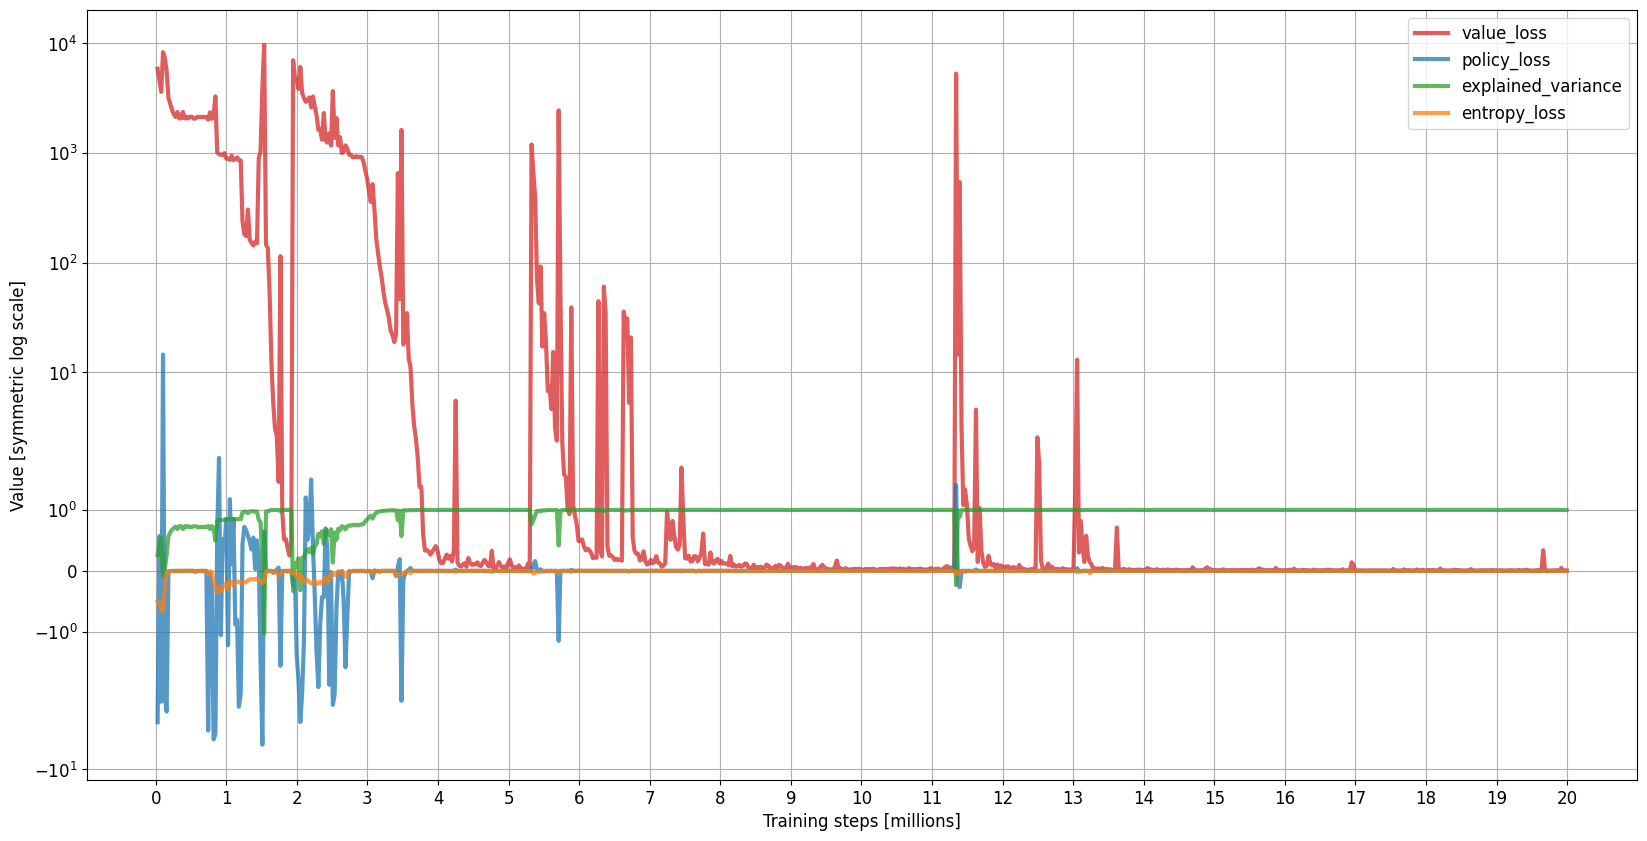

In [59]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})

for col, c in zip(['train/value_loss', 'train/policy_loss', 'train/explained_variance', 'train/entropy_loss'], 
                  ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']):
    
    plt.plot(log_df['time/total_timesteps'], log_df[col], c=c, label=col[6:], alpha=0.75, linewidth=3.0)
    #plt.scatter(log_df['time/total_timesteps'], log_df[col], c=c, marker='X', , alpha=0.5)
    
plt.yscale('symlog')
plt.xlabel('Training steps [millions]')
plt.ylabel('Value [symmetric log scale]')

plt.xticks(ticks=range(0, 21000000, 1000000), labels=range(0, 21, 1))
plt.legend(loc='upper right')
plt.grid()
plt.savefig('A2C15v2_training_log_plot', bbox_inches='tight', pad_inches=0.3)
plt.show()
plt.close()